<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/google-cloud-views/mimic-code/notebooks/insulin_glucose_pairing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification of Critically-ill Patients Under Insulin Therapy for Glucose Control
## Interactive notebook

Authors: [Aldo Robles Arévalo](mailto:aldo.arevalo@tecnico.ulisboa.pt); Lawrence Baker; Francis DeMichele; Susana M. da Silva Vieira; João M. da Costa Sousa; Stan Finkelstein; Roselyn Cristelle, Leo Celi

## Overview

This notebook contains the curation and pre-processing process to extract glucose readings and insulin inputs from  the Medical Information Mart for Intensive Care (MIMIC).

## Code

### Import dependencies and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.colors as colors

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML, Math, Latex

# Imports for accessing data using Google BigQuery.
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

# To download dataframes
from google.colab import files

# Imports to ignore warnings to improve notebook visualization
import warnings

def q(query,projectid):
    client = bigquery.Client(location="US",project=projectid)
    # Location must match that of the dataset(s) referenced in the query.
    query_job = client.query(query,
    location="US",)  # API re
    return query_job.to_dataframe()

Authenticated


### Verify client name

The project id would depend on your credentials.

Verify the location of server hosting the database.

In [2]:
client = bigquery.Client(location="US",project = "fluent-empire-241300")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: fluent-empire-241300


## Extraction of insulin events

The following item id's are extracted

| Item id | Insulin type |
|---------|:------------:|
| 223257  |'Intermediate'|
| 223258  |   'Short'    |
| 223259  |'Intermediate'|
| 223260  |   'Long'     |
| 223261  |'Intermediate'|
| 223262  |   'Short'    |

In [3]:
# Import Insulin input raw
projectid = "milan-datathon"
query = """
    SELECT atr.SUBJECT_ID, atr.HADM_ID, atr.ICUSTAY_ID
        , CAST(atr.starttime AS TIMESTAMP) AS STARTTIME
        , CAST(atr.endtime AS TIMESTAMP) AS ENDTIME
        , atr.AMOUNT, atr.RATE, atr.ORIGINALRATE, atr.ITEMID
        , atr.ORDERCATEGORYNAME
        , (CASE
            WHEN itemid=223257 THEN 'Intermediate' --'Ins7030'
            WHEN itemid=223258 THEN 'Short'        --'InsRegular'
            WHEN itemid=223259 THEN 'Intermediate' --'InsNPH'
            WHEN itemid=223260 THEN 'Long'         --'InsGlargine'
            WHEN itemid=223261 THEN 'Intermediate' --'InsHum7525'
            WHEN itemid=223262 THEN 'Short'        --'InsHum'
            ELSE null END) AS InsulinType
        , (CASE
            WHEN UPPER(ORDERCATEGORYNAME) LIKE '%NON IV%' THEN 'BOLUS_INYECTION'
            WHEN UPPER(ORDERCATEGORYNAME) LIKE '%MED BOLUS%' THEN 'BOLUS_PUSH'
            WHEN ORDERCATEGORYNAME IN ('01-Drips','12-Parenteral Nutrition') THEN 'INFUSION'
            ELSE null END) AS InsulinAdmin
        , (CASE WHEN STATUSDESCRIPTION IN ('Paused','Stopped') THEN 1 ELSE NULL END) AS INFXSTOP
        , CAST(atr.STORETIME AS TIMESTAMP) AS STORETIME
    FROM `physionet-data.mimiciii_clinical.inputevents_mv` atr								
    WHERE itemid IN (223257 -- [Ins7030]     - Insulin 70/30 
                    , 223258 -- [InsRegular]  - Insulin Regular
                    , 223259 -- [InsNPH]      - Insulin NPH
                    , 223260 -- [InsGlargine] - Insulin Glargine
                    , 223261 -- [nsHum7525]   - Insulin Humalog 75/25
                    , 223262) -- [InsHum]      - Insulin Humalog
    AND atr.statusdescription != 'Rewritten' --Exclude invalid measures that were rewritten
    GROUP BY atr.subject_id, atr.hadm_id, atr.icustay_id, atr.starttime
    , atr.endtime, atr.STORETIME, atr.ITEMID, atr.ordercategoryname
    , atr.statusdescription, atr.amount, atr.rate, atr.ORIGINALRATE
    ORDER BY atr.icustay_id, atr.subject_id, atr.hadm_id, atr.starttime
    """ 

insulin_mv = q(query,projectid)

display(insulin_mv.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
0,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 12:30:00+00:00,2.000000,NaN,2.0,223258,05-Med Bolus,Short,BOLUS_PUSH,NaN,2204-10-26 12:29:00+00:00
1,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 13:54:00+00:00,2.833333,2.000000,2.0,223258,01-Drips,Short,INFUSION,NaN,2204-10-26 12:29:00+00:00
2,963,190225,NaN,2204-10-26 13:54:00+00:00,2204-10-26 16:08:00+00:00,6.701149,3.000515,3.0,223258,01-Drips,Short,INFUSION,NaN,2204-10-26 13:54:00+00:00
3,963,190225,NaN,2204-10-26 16:08:00+00:00,2204-10-26 18:11:00+00:00,2.050352,1.000171,1.0,223258,01-Drips,Short,INFUSION,NaN,2204-10-26 16:08:00+00:00
4,963,190225,NaN,2204-10-26 18:11:00+00:00,2204-10-26 19:07:00+00:00,1.866987,2.000343,2.0,223258,01-Drips,Short,INFUSION,NaN,2204-10-26 18:11:00+00:00


In [4]:
# Coerse columns
insulin_mv[["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]] = insulin_mv[
        ["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]].apply(pd.to_numeric
        , errors='coerce')

# Display results
display(HTML('<h5>It contains the following information</h5>'))
print("Observations: {}".format(insulin_mv.shape[0]))
print("Patients: {}".format(insulin_mv['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(insulin_mv['HADM_ID'].nunique()))
print('ICU stays: {}'.format(insulin_mv['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(insulin_mv['ITEMID'].value_counts())

display(HTML('<h5>Verify column types</h5>'))
display(insulin_mv.dtypes)

Observations: 151207
Patients: 9638
Hospital admissions: 11236
ICU stays: 11882


223258    108241
223262     30342
223260      8642
223259      3383
223257       441
223261       158
Name: ITEMID, dtype: int64

SUBJECT_ID                         int64
HADM_ID                            int64
ICUSTAY_ID                       float64
STARTTIME            datetime64[ns, UTC]
ENDTIME              datetime64[ns, UTC]
AMOUNT                           float64
RATE                             float64
ORIGINALRATE                     float64
ITEMID                             int64
ORDERCATEGORYNAME                 object
InsulinType                       object
InsulinAdmin                      object
INFXSTOP                         float64
STORETIME            datetime64[ns, UTC]
dtype: object

In [5]:
# Drop missing ICU stays

insulin_mv = insulin_mv.dropna(subset=["ICUSTAY_ID"])

display(insulin_mv.describe())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,AMOUNT,RATE,ORIGINALRATE,ITEMID,INFXSTOP
count,151162.000000,151162.000000,151162.000000,151162.000000,44632.000000,151162.000000,151162.000000,7152.0
mean,63093.186581,150538.835468,249874.901080,7.819068,5.663981,11.303023,223258.939773,1.0
std,23339.386173,28647.967593,29008.942808,10.978646,12.097432,1956.376235,1.609842,0.0
min,23.000000,100001.000000,200010.000000,0.000000,0.049999,0.000000,223257.000000,1.0
25%,48204.000000,125843.000000,224516.000000,2.000000,2.001075,2.000000,223258.000000,1.0
50%,64921.000000,150871.000000,250075.000000,4.000000,4.000000,4.000000,223258.000000,1.0
75%,81923.000000,175448.000000,275509.000000,8.558515,6.034062,7.000000,223260.000000,1.0
max,99992.000000,199979.000000,299998.000000,500.000015,1084.031880,760627.000000,223262.000000,1.0


### Short-acting infusions
Only short-acting infusions exist

In [6]:
# Filter infusions
MV_infusions = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('INFUSION'))]

display(MV_infusions.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
118,74282,121149,200061.0,2134-01-23 23:08:00+00:00,2134-01-24 00:00:00+00:00,0.866667,1.000000,1.0,223258,01-Drips,Short,INFUSION,NaN,2134-01-24 00:08:00+00:00
119,74282,121149,200061.0,2134-01-24 00:00:00+00:00,2134-01-24 01:00:00+00:00,2.000000,2.000000,2.0,223258,01-Drips,Short,INFUSION,NaN,2134-01-24 00:09:00+00:00
120,74282,121149,200061.0,2134-01-24 01:00:00+00:00,2134-01-24 02:01:00+00:00,3.049477,2.999485,3.0,223258,01-Drips,Short,INFUSION,NaN,2134-01-24 01:28:00+00:00
121,74282,121149,200061.0,2134-01-24 02:01:00+00:00,2134-01-24 03:05:00+00:00,5.333363,5.000028,5.0,223258,01-Drips,Short,INFUSION,NaN,2134-01-24 02:19:00+00:00
122,74282,121149,200061.0,2134-01-24 03:05:00+00:00,2134-01-24 04:02:00+00:00,6.647539,6.997410,7.0,223258,01-Drips,Short,INFUSION,NaN,2134-01-24 03:19:00+00:00


In [7]:
# Display results
display(HTML('<h5>Statistics</h5>'))
display(MV_infusions[['RATE','ORIGINALRATE']].describe())

display(HTML('<h5>Infusions contains the following information</h5>'))
print("Observations: {}".format(MV_infusions.shape[0]))
print("Patients: {}".format(MV_infusions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_infusions['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_infusions['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

,RATE,ORIGINALRATE
count,44632.000000,45623.000000
mean,5.663981,22.207227
std,12.097432,3561.058557
min,0.049999,0.000000
25%,2.001075,2.000000
50%,4.000000,4.000000
75%,6.034062,6.000000
max,1084.031880,760627.000000


Observations: 45623
Patients: 3621
Hospital admissions: 3829
ICU stays: 3879


223258    45623
Name: ITEMID, dtype: int64

### Short-acting boluses

In [8]:
# Filter short-acting boluses
MV_bol_short = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))]

display(MV_bol_short.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
45,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 16:12:00+00:00
46,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 16:12:00+00:00
47,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 21:28:00+00:00
49,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2127-03-03 18:21:00+00:00
50,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2133-10-29 22:15:00+00:00


In [9]:
# Display results
display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Short-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_short.shape[0]))
print("Patients: {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

,AMOUNT
count,92916.000000
mean,4.598589
std,4.241005
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,223.000000


Observations: 92916
Patients: 9496
Hospital admissions: 11029
ICU stays: 11652


In [10]:
# Remove doses <= 0 U
MV_bol_short = MV_bol_short[MV_bol_short['AMOUNT'] > 0]

# Estimate 99th percentile for outlier removal
P99_bol_s = MV_bol_short['AMOUNT'].quantile(.99)

# Drop boluses over 99th percentile
MV_bol_short = MV_bol_short[(MV_bol_short['AMOUNT'] < (MV_bol_short['AMOUNT'].quantile(.99)))]

# Display results
display(HTML('<h5>Short-acting boluses 99th percentile</h5>'))
display('P99: {:.3f}'.format(P99_bol_s))

display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Short-acting boluses contains the following updated information</h5>'))
print("Observations: {}".format(MV_bol_short.shape[0]))
print("Patients: {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_short['ITEMID'].value_counts())

'P99: 18.000'

,AMOUNT
count,88473.000000
mean,4.518098
std,3.038432
min,0.100000
25%,2.000000
50%,4.000000
75%,6.000000
max,17.000000


Observations: 88473
Patients: 9370
Hospital admissions: 10877
ICU stays: 11484


223258    59850
223262    28623
Name: ITEMID, dtype: int64

### Intermediate-acting insulin boluses

In [11]:
# Filter intermediate-acting insulin
MV_bol_inter = insulin_mv[(insulin_mv['InsulinType']=="Intermediate") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))]

display(MV_bol_inter.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
248,50772,192069,200108.0,2110-12-10 18:00:00+00:00,2110-12-10 18:01:00+00:00,11.0,NaN,11.0,223257,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,NaN,2110-12-10 19:13:00+00:00
848,69110,131817,200636.0,2123-02-08 13:17:00+00:00,2123-02-08 13:18:00+00:00,4.0,NaN,4.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,NaN,2123-02-08 13:17:00+00:00
1022,4588,186721,200746.0,2113-03-04 10:29:00+00:00,2113-03-04 10:30:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,NaN,2113-03-04 10:29:00+00:00
1190,70148,195958,200924.0,2173-11-19 22:31:00+00:00,2173-11-19 22:32:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,NaN,2173-11-19 22:31:00+00:00
1191,70148,195958,200924.0,2173-11-20 10:39:00+00:00,2173-11-20 10:40:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,NaN,2173-11-20 11:39:00+00:00


In [12]:
# Remove doses <= 0 U
MV_bol_inter = MV_bol_inter[MV_bol_inter['AMOUNT'] > 0]

# Display results
display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_inter[['AMOUNT']].describe())

display(HTML('<h5>Intermediate-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_inter.shape[0]))
print("Patients: {}".format(MV_bol_inter['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_inter['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_inter['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_inter['ITEMID'].value_counts())

,AMOUNT
count,3962.000000
mean,18.572438
std,15.330288
min,1.000000
25%,8.000000
50%,15.000000
75%,25.000000
max,180.000000


Observations: 3962
Patients: 680
Hospital admissions: 781
ICU stays: 813


223259    3369
223257     437
223261     156
Name: ITEMID, dtype: int64

### Long-acting insulin boluses

In [13]:
# Filter long-acting insulin boluses
MV_bol_long = insulin_mv[(insulin_mv['InsulinType']=="Long") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))]

display(MV_bol_long.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
48,11861,192256,200010.0,2132-08-05 21:29:00+00:00,2132-08-05 21:30:00+00:00,20.0,NaN,20.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,NaN,2132-08-05 21:29:00+00:00
51,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,40.0,NaN,40.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,NaN,2133-10-29 22:15:00+00:00
56,41710,181955,200028.0,2133-10-30 22:21:00+00:00,2133-10-30 22:22:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,NaN,2133-10-30 22:21:00+00:00
61,41710,181955,200028.0,2133-10-31 22:00:00+00:00,2133-10-31 22:01:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,NaN,2133-10-31 22:44:00+00:00
69,56369,198650,200033.0,2198-08-11 08:00:00+00:00,2198-08-11 08:01:00+00:00,10.0,NaN,10.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,NaN,2198-08-11 09:38:00+00:00


In [14]:
# Remove doses <= 0 U
MV_bol_long = MV_bol_long[MV_bol_long['AMOUNT'] > 0]

display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_long[['AMOUNT']].describe())

display(HTML('<h5>Long-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_long.shape[0]))
print("Patients: {}".format(MV_bol_long['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_long['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_long['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_long['ITEMID'].value_counts())

,AMOUNT
count,8627.000000
mean,23.382068
std,16.147520
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,180.000000


Observations: 8627
Patients: 2908
Hospital admissions: 3314
ICU stays: 3408


223260    8627
Name: ITEMID, dtype: int64

### Merging boluses and infusions

This operation will gather the curated data of each insulin type analyzed above.

In [15]:
frames = [MV_bol_short, MV_bol_inter, MV_infusions, MV_bol_long]
MV_insulin_all = pd.concat(frames, sort = True, verify_integrity=True
                             , ignore_index=True, axis = 0)
cols = list(MV_bol_short.columns)
MV_insulin_all = MV_insulin_all[cols]

del frames, cols

# Display first lines
display(MV_insulin_all.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP,STORETIME
0,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 16:12:00+00:00
1,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 16:12:00+00:00
2,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2132-08-05 21:28:00+00:00
3,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2127-03-03 18:21:00+00:00
4,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,NaN,2133-10-29 22:15:00+00:00


In [16]:
# Display statistics

display(HTML('<h5>Statistics of all insulin doses</h5>'))
display(MV_insulin_all[['AMOUNT','RATE']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(MV_insulin_all.shape[0]))
print("Patients: {}".format(MV_insulin_all['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_insulin_all['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_insulin_all['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_insulin_all['ITEMID'].value_counts())

# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(MV_insulin_all['InsulinAdmin'].value_counts())

,AMOUNT,RATE
count,146685.000000,44632.000000
mean,7.869879,5.663981
std,10.879814,12.097432
min,0.000833,0.049999
25%,2.000000,2.001075
50%,4.000000,4.000000
75%,8.552876,6.034062
max,500.000015,1084.031880


Observations: 146685
Patients: 9521
Hospital admissions: 11097
ICU stays: 11729


223258    105473
223262     28623
223260      8627
223259      3369
223257       437
223261       156
Name: ITEMID, dtype: int64

BOLUS_INYECTION    91761
INFUSION           45623
BOLUS_PUSH          9301
Name: InsulinAdmin, dtype: int64

## Glucose readings

The following item id's were identified:

| Item id | Description                 | Source    |
|:-------:|-----------------------------|:---------:|
| 807     |Fingerstick Glucose          |CHARTEVENTS|
| 811     | Glucose (70-105)            |CHARTEVENTS|
| 1529    | Glucose                     |CHARTEVENTS|
| 3745    | BloodGlucose                |CHARTEVENTS|
| 3744    | Blood Glucose               |CHARTEVENTS|
| 225664  | Glucose finger stick        |CHARTEVENTS|
| 220621  | Glucose (serum)             |CHARTEVENTS|
| 226537  | Glucose (whole blood)       |CHARTEVENTS|
| 50931   | GLUCOSE CHEMISTRY BLOOD     |LABEVENTS  |
| 50809   | GLUCOSE BLOOD GAS BLOOD)    |LABEVENTS  |

In [17]:
warnings.simplefilter('ignore')

# Import raw glucose readings
projectid = "milan-datathon"
query = """
        WITH chart AS(
          SELECT ce.subject_id, ce.hadm_id, ce.icustay_id, ce.charttime, ce.storetime
          , (CASE
              WHEN itemid IN (811,1529,3745,3744,220621,226537,807,225664)
              AND ce.valuenum > 0
              THEN valuenum            
             ELSE null END) AS Glu_Chart
          , ce.itemid, 1 AS idi
          FROM `physionet-data.mimiciii_clinical.chartevents` ce
          WHERE ce.itemid IN(807,  -- Fingerstick Glucose
                           811,   --	Glucose (70-105)
                           1529,  --	Glucose
                           3745,  --	BloodGlucose
                           3744,  --	Blood Glucose
                           225664,--	Glucose finger stick
                           220621,--	Glucose (serum)
                           226537 --	Glucose (whole blood)
                           )
          AND (ce.error IS null OR ce.error <> 1)
        )
        , labv AS(
          SELECT le.SUBJECT_ID, le.HADM_ID, le.CHARTTIME 
          , (CASE
              WHEN itemid IN (50809,50931) AND valuenum > 0
              THEN valuenum ELSE null END) AS Glu_Labv
          , itemid, 2 AS idi
          FROM `physionet-data.mimiciii_clinical.labevents` le	 
          WHERE le.itemid IN(50931  -- GLUCOSE | CHEMISTRY | BLOOD 
                            , 50809)-- GLUCOSE | BLOOD GAS | BLOOD)
        )
        -- Join both tables
        SELECT pt.SUBJECT_ID, pt.HADM_ID, pt.ICUSTAY_ID
        , CAST(pt.CHARTTIME AS TIMESTAMP) AS CHARTTIME
        , CAST(pt.STORETIME AS TIMESTAMP) AS STORETIME
        , pt.glucose
        , COALESCE(pt.CH, pt.LB) AS ITEM_GLC
        FROM (
        SELECT subject_id, hadm_id, null AS icustay_id, charttime
              , null AS storetime, glu_labv AS glucose, itemid AS LB, null AS CH 
              FROM labv AS le
              UNION ALL
              SELECT subject_id, hadm_id, icustay_id, charttime, storetime, Glu_Chart, null
              , itemid FROM chart as ce
              ) pt
        WHERE pt.glucose IS NOT null
        GROUP BY pt.subject_id,pt.hadm_id,pt.ICUSTAY_ID,pt.charttime,pt.STORETIME,glucose,pt.CH,pt.LB
        ORDER BY subject_id,hadm_id,ICUSTAY_ID,charttime
    """ 

Glucose = q(query,projectid)

del query

# Coerse columns
Glucose[["CHARTTIME","STORETIME"]] = Glucose[
    ["CHARTTIME","STORETIME"]].apply(pd.to_datetime, format='%Y%m%d %H:%M:%S')

# Display first rows
display(Glucose.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,STORETIME,glucose,ITEM_GLC
0,2,163353.0,243653.0,2138-07-17 20:30:00+00:00,2138-07-17 22:07:00+00:00,72.0,3745
1,3,NaN,NaN,2101-10-04 15:24:00+00:00,NaT,121.0,50931
2,3,NaN,NaN,2101-10-05 06:00:00+00:00,NaT,116.0,50931
3,3,NaN,NaN,2101-10-06 05:45:00+00:00,NaT,94.0,50931
4,3,NaN,NaN,2101-10-07 04:30:00+00:00,NaT,92.0,50931


In [18]:
# Display statistics

display(HTML('<h5>Statistics of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose.shape[0]))
print("Patients: {}".format(Glucose['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['ITEM_GLC'].value_counts())

,glucose
count,2.508737e+06
mean,1.377641e+02
std,8.947669e+02
min,1.060000e-01
25%,1.030000e+02
50%,1.250000e+02
75%,1.550000e+02
max,9.999990e+05


Observations: 2508737
Patients: 41395
Hospital admissions: 53078
ICU stays: 54601


50931     748747
807       431010
811       374668
1529      283795
225664    246001
50809     196591
220621    154525
226537     70231
3745        2639
3744         530
Name: ITEM_GLC, dtype: int64

#### Item id's distributions

The following chunk would let us to visualizae the distributions of each item id related with glucose readings before futher curation.

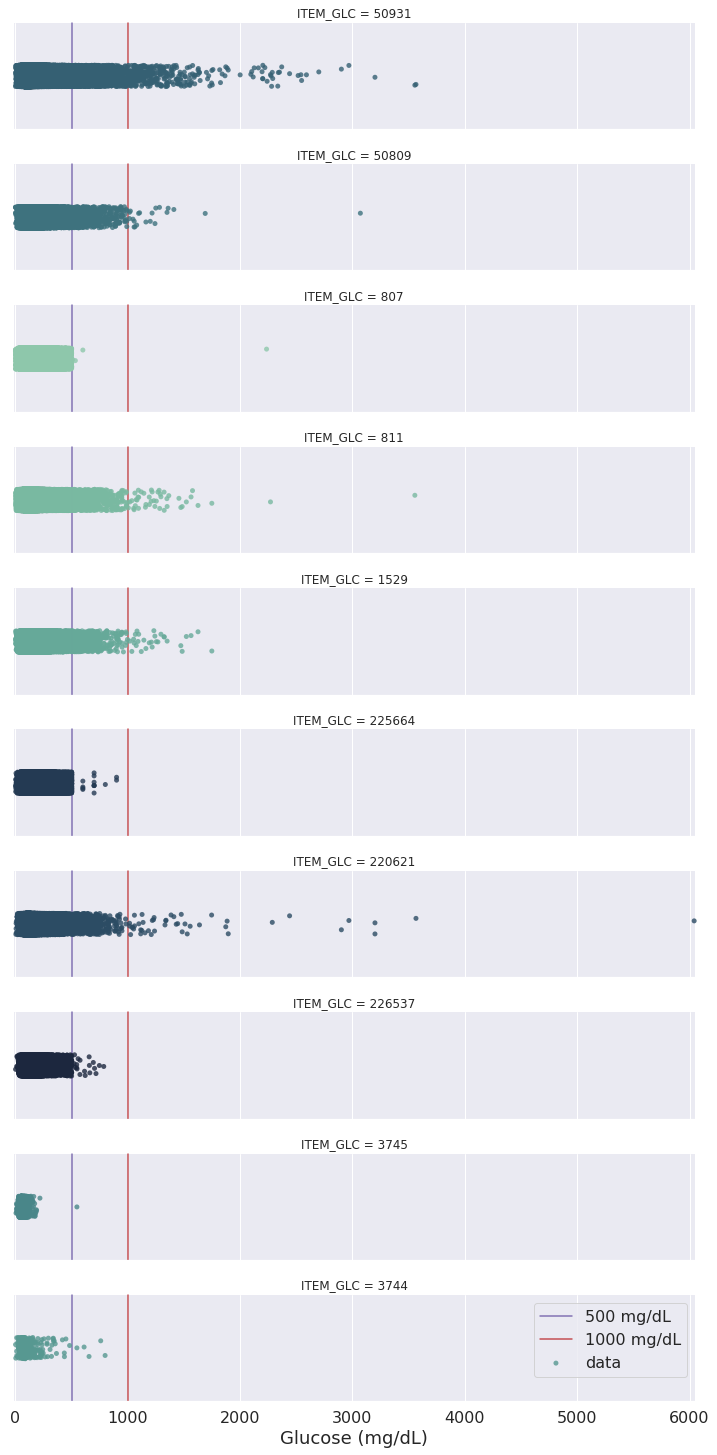

In [19]:
# Initialize the FacetGrid object
sns.set(style="darkgrid", rc=None)

# Plot
pal = sns.cubehelix_palette((Glucose['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,811,1529
                                                                          ,225664,220621,226537
                                                                          ,3745,3744]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

#### Joining information from glucose readings and insulin events.

Including only glucose readings from patients that received any insulin input 

,glucose
count,592623.000000
mean,150.971047
std,1838.046844
min,0.133000
25%,110.000000
50%,133.000000
75%,167.000000
max,999999.000000


Observations: 592623
Patients: 9521
Hospital admissions: 11097
ICU stays: 12227


225664    219093
50931     158796
220621     98056
226537     58431
50809      51081
1529        3020
811         3020
807         1126
Name: ITEM_GLC, dtype: int64

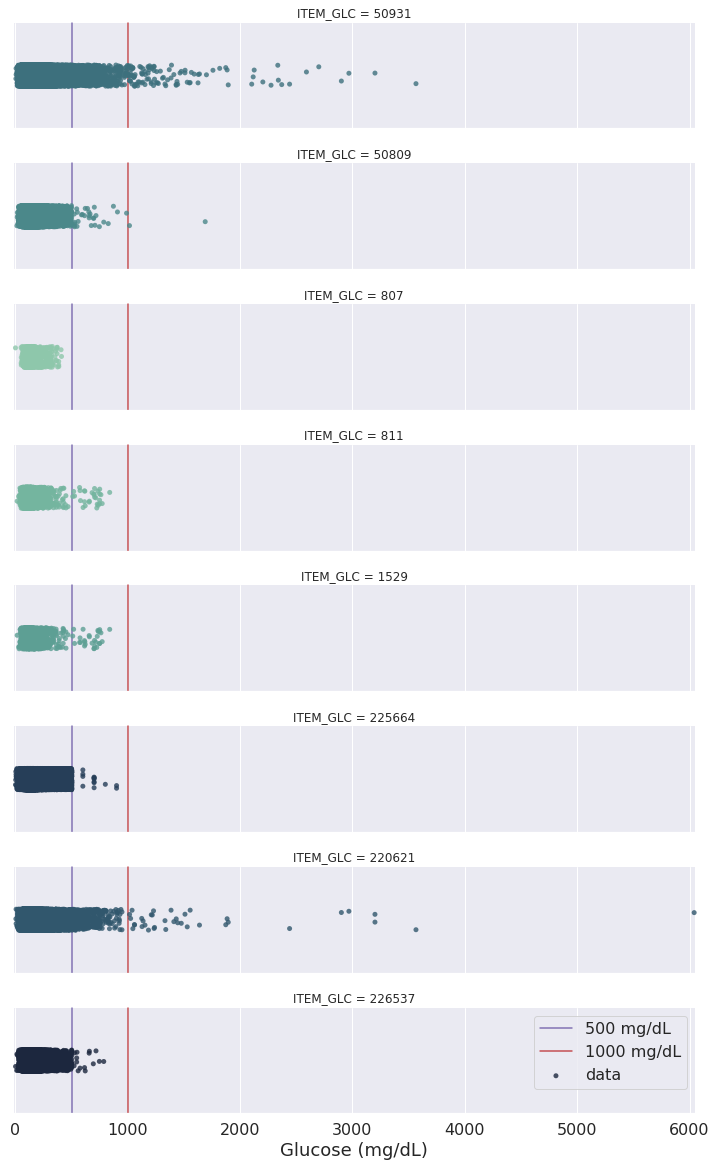

In [20]:
# Include patients that have insulin info

insulin_mv_patients = list(MV_insulin_all.HADM_ID.dropna().unique())

Glucose = Glucose[Glucose['HADM_ID'].isin(insulin_mv_patients)]

# Display statistics (updated)
display(HTML('<h5>Statistics of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose.shape[0]))
print("Patients: {}".format(Glucose['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,811,1529
                                                                          ,225664,220621,226537]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

plt.show()

,glucose
count,534039.000000
mean,151.988182
std,1936.127584
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999999.000000


Observations: 534039
Patients: 9521
Hospital admissions: 11097
ICU stays: 12227


225664    217834
50931     122599
220621     96588
226537     58111
50809      34946
811         1441
1529        1402
807         1118
Name: ITEM_GLC, dtype: int64

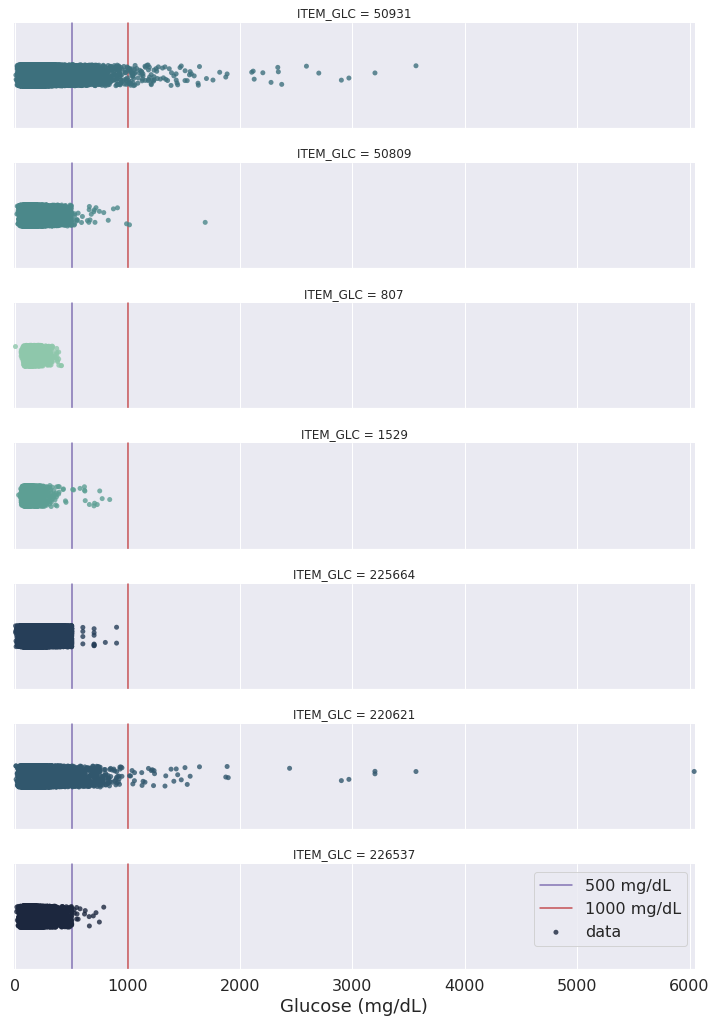

In [21]:
# Remove duplicated: same subject id, hadm id, and charttime
Glucose = Glucose.drop_duplicates(["SUBJECT_ID","HADM_ID","CHARTTIME"], keep= 'last')
Glucose['GLCSOURCE'] = np.nan

# Display statistics (updated)
display(HTML('<h5>Statistics of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose.shape[0]))
print("Patients: {}".format(Glucose['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,1529
                                                                          ,225664,220621,226537]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

plt.show()

#### Fingerstick & Lab analyzer

The following sections is going to analyze the different measuring methodologies

In [22]:
# Filter fingerstick
Glucose_step3_finger = Glucose[(Glucose['ITEM_GLC'] == 807) | 
        (Glucose['ITEM_GLC'] == 225664) | (Glucose['ITEM_GLC'] == 226537) | 
        (Glucose['ITEM_GLC'] == 811) | (Glucose['ITEM_GLC'] == 1529) ]

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_finger.shape[0]))
print("Patients: {}".format(Glucose_step3_finger['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_finger['ICUSTAY_ID'].nunique()))

,glucose
count,279906.000000
mean,155.156400
std,1890.896193
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,999999.000000


Observations: 279906
Patients: 9489
Hospital admissions: 11054
ICU stays: 12025


In [23]:
warnings.simplefilter('ignore')

# Remove values over 499
Glucose_step3_finger_sat = Glucose_step3_finger[(Glucose_step3_finger['glucose'] < 500)]

# Add flag column
Glucose_step3_finger_sat['GLCSOURCE'] = "FINGERSTICK"

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger_sat[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_finger_sat.shape[0]))
print("Patients: {}".format(Glucose_step3_finger_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger_sat['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_finger_sat['ICUSTAY_ID'].nunique()))

,glucose
count,279760.000000
mean,151.336800
std,59.273753
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,499.000000


Observations: 279760
Patients: 9488
Hospital admissions: 11052
ICU stays: 12023


In [24]:
# Filter lab samples
Glucose_step3_blood = Glucose[((Glucose['ITEM_GLC'] == 3745) | 
        (Glucose['ITEM_GLC'] == 220621) | (Glucose['ITEM_GLC'] == 50931) | 
        (Glucose['ITEM_GLC'] == 50809)
        )]

# Display statistics (updated)
display(HTML('<h5>Statistics for lab samples</h5>'))
display(Glucose_step3_blood[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_blood.shape[0]))
print("Patients: {}".format(Glucose_step3_blood['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_blood['ICUSTAY_ID'].nunique()))

,glucose
count,254133.000000
mean,148.498659
std,1984.751468
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999999.000000


Observations: 254133
Patients: 9520
Hospital admissions: 11095
ICU stays: 12078


In [25]:
# Remove values over 1000
Glucose_step3_blood_sat = Glucose_step3_blood[(Glucose_step3_blood['glucose'] < 1000)]

# Add flag column
Glucose_step3_blood_sat['GLCSOURCE'] = "BLOOD"

# Display statistics (updated)
display(HTML('<h5>Statistics for lab samples</h5>'))
display(Glucose_step3_blood_sat[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_blood_sat.shape[0]))
print("Patients: {}".format(Glucose_step3_blood_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood_sat['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_blood_sat['ICUSTAY_ID'].nunique()))

,glucose
count,253989.000000
mean,143.797892
std,64.280592
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999.000000


Observations: 253989
Patients: 9520
Hospital admissions: 11095
ICU stays: 12078


In [26]:
warnings.simplefilter('default')

# Merge both sources

Glucose_step3 = pd.concat([Glucose_step3_finger_sat, Glucose_step3_blood_sat]
, keys=['SUBJECT_ID', 'HADM_ID'], verify_integrity=True
, ignore_index=True)

# Display statistics (updated)
display(HTML('<h5>Statistics for all glucose readings</h5>'))
display(Glucose_step3[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3.shape[0]))
print("Patients: {}".format(Glucose_step3['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3['ICUSTAY_ID'].nunique()))

,glucose
count,533749.000000
mean,147.749346
std,61.821682
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999.000000


Observations: 533749
Patients: 9521
Hospital admissions: 11097
ICU stays: 12227


#### CHARTTIME and STORETIME disadjustment

<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence \D
<input>:41: DeprecationWarning: invalid escape sequence 

,glucose
count,44852.000000
mean,157.368635
std,60.988251
min,1.000000
25%,117.000000
50%,143.000000
75%,181.000000
max,600.000000


Observations: 44852
Patients: 7763
Hospital admissions: 8927
ICU stays: 9476


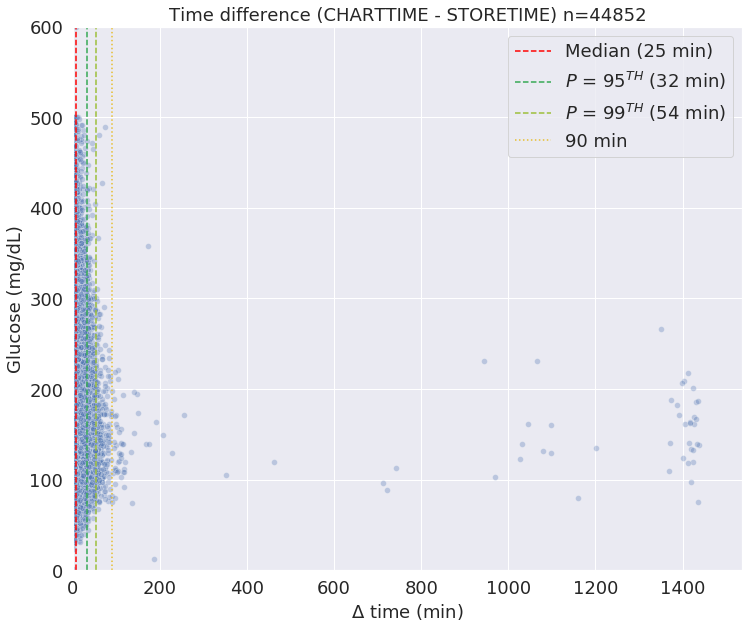

In [27]:
warnings.simplefilter('ignore')

# Find: (CASE WHEN pt.charttime < pt.storetime THEN pt.charttime ELSE pt.storetime END) AS timer_
Glucose['CHART_STORE'] = Glucose['CHARTTIME'] > Glucose['STORETIME']
Glucose_final = Glucose_step3.copy()
Glucose_final['CHART_STORE'] = Glucose_final['CHARTTIME'] > Glucose_final['STORETIME']

# Replace
Glucose_final.loc[(Glucose_final['CHART_STORE'] == True),'CHARTTIME'] = Glucose_final['STORETIME']

# Create subset for plotting
step4_switch_cases = Glucose[(Glucose.CHART_STORE == True)].copy()
step4_switch_cases['TIMEDELTA'] = abs(step4_switch_cases.CHARTTIME 
                  - step4_switch_cases.STORETIME).dt.seconds

# Display statistics
display(HTML('<h5>Statistics for all glucose readings that got switched their time stamps</h5>'))
display(step4_switch_cases[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(step4_switch_cases.shape[0]))
print("Patients: {}".format(step4_switch_cases['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(step4_switch_cases['HADM_ID'].nunique()))
print('ICU stays: {}'.format(step4_switch_cases['ICUSTAY_ID'].nunique()))

# Scatterplottimedelta
plt.figure(figsize=(12,10))
df = step4_switch_cases.loc[step4_switch_cases['CHART_STORE']==True]
df['TIMEDELTA']=df['TIMEDELTA']/60
sns.scatterplot(x="TIMEDELTA",y="glucose",data=df,alpha=0.3)
plt.title('Time difference (CHARTTIME - STORETIME) n='+str(df.shape[0])
        ,fontsize=18)
plt.vlines(df['TIMEDELTA'].quantile(0.50), 0, max(df.glucose)
    , color = 'red', linestyles='--',label='Median (25 min)')
plt.vlines(df['TIMEDELTA'].quantile(0.95), 0, max(df.glucose)
    , color = '#34A853', linestyles='--',label='$P$ = 95$^{TH}$ (32 min)')
plt.vlines(df['TIMEDELTA'].quantile(0.99), 0, max(df.glucose)
    , color = '#9CBF38', linestyles='--',label='$P$ = 99$^{TH}$ (54 min)')
plt.vlines(90, 0, max(df.glucose), color = '#E7BE2D', linestyles='dotted'
           ,label='90 min')
plt.xlabel('$\Delta$ time (min)', fontsize=18)
plt.ylabel('Glucose (mg/dL)', fontsize=18)
plt.ylim(0,(max(df.glucose)))
plt.xlim(0,(max(df.TIMEDELTA)+100))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.legend(fontsize=18)
plt.show()

## Curated datasets

In [0]:
warnings.simplefilter('ignore')

# Glucose readings (14 columns)
Glucose_cur = Glucose_final[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CHARTTIME'
                              ,'glucose','GLCSOURCE','CHART_STORE']]
Glucose_cur['STARTTIME'] = pd.NaT
Glucose_cur['ENDTIME'] = pd.NaT
Glucose_cur['INPUT'] = np.nan
Glucose_cur['INPUT_HRS'] = np.nan
Glucose_cur['INSULINTYPE'] = np.nan
Glucose_cur['EVENT'] = np.nan
Glucose_cur['INFXSTOP'] = np.nan

Glucose_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'GLCTIMER'
                         , 'GLC', 'GLCSOURCE','CHART_STORE', 'STARTTIME'
                         , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE'
                         , 'EVENT', 'INFXSTOP']



# Insulin events
Insulin_cur = MV_insulin_all[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'
                               , 'STARTTIME', 'ENDTIME', 'AMOUNT', 'RATE'
                               , 'InsulinType', 'InsulinAdmin', 'INFXSTOP']]
Insulin_cur['GLCTIMER'] = pd.NaT
Insulin_cur['GLCSOURCE'] = np.nan
Insulin_cur['GLC'] = np.nan
Insulin_cur['CHART_STORE'] = np.nan

Insulin_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'CHART_STORE', 'GLCTIMER'
                      , 'GLC','GLCSOURCE']

**Export these curated datasets to BigQuery.**

It is assumed that you build the MIMIC III database in BigQuery and have credentials to load new tables.

Insulin_cur as `insulin_cur` and Glucose_cur as `glc_cur` will be uploaded according to the following code.

```python
# Here goes the name of the dataset or schema if you are familiarized with PSQL
dataset_ref = client.dataset('icuinsulintherapy')

# Assign the name for the table
table_ref = dataset_ref.table('insulin_cur')

client.load_table_from_dataframe(Insulin_cur, table_ref).result()
```

You should be able to read something similar to the following warning:

```python
<google.cloud.bigquery.job.LoadJob at 0x7f71be8f0a20>
```

In [29]:
# Concatenate subsets
warnings.simplefilter('ignore')

# Concatenate Glucose and insulin values

Glc_Ins = pd.concat([Insulin_cur, Glucose_cur], sort = True, ignore_index = True)

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'GLCTIMER', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

Glc_Ins['TIMER'] = pd.NaT

# Reset index
Glc_Ins = Glc_Ins.reset_index()

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'TIMER' ,'STARTTIME'
                      , 'GLCTIMER', 'ENDTIME', 'INPUT', 'INPUT_HRS'
                      , 'INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE', 'INFXSTOP']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

# Create a column that contains all timestamps ordered chronologically
Glc_Ins['TIMER'] = Glc_Ins['GLCTIMER']
Glc_Ins['TIMER'].loc[
        (Glc_Ins['TIMER'].isnull())] = Glc_Ins.loc[
                (Glc_Ins['TIMER'].isnull()),'STARTTIME']
Glc_Ins = Glc_Ins.sort_values(by = ['SUBJECT_ID', 'HADM_ID', 'TIMER'])

display(Glc_Ins.head())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glc_Ins.shape[0]))
print("Patients: {}".format(Glc_Ins['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glc_Ins['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glc_Ins['ICUSTAY_ID'].nunique()))

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TIMER,STARTTIME,GLCTIMER,ENDTIME,INPUT,INPUT_HRS,INSULINTYPE,EVENT,GLC,GLCSOURCE,CHART_STORE,INFXSTOP
0,23,124321.0,NaN,2157-10-19 03:55:00+00:00,NaT,2157-10-19 03:55:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN
1,23,124321.0,NaN,2157-10-20 04:00:00+00:00,NaT,2157-10-20 04:00:00+00:00,NaT,NaN,NaN,NaN,NaN,167.0,BLOOD,False,NaN
2,23,124321.0,NaN,2157-10-21 03:40:00+00:00,NaT,2157-10-21 03:40:00+00:00,NaT,NaN,NaN,NaN,NaN,134.0,BLOOD,False,NaN
3,23,124321.0,NaN,2157-10-21 07:55:00+00:00,NaT,2157-10-21 07:55:00+00:00,NaT,NaN,NaN,NaN,NaN,122.0,BLOOD,False,NaN
4,23,124321.0,NaN,2157-10-21 10:27:00+00:00,NaT,2157-10-21 10:27:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN


Observations: 680434
Patients: 9521
Hospital admissions: 11097
ICU stays: 12227


In [32]:
warnings.simplefilter('default')

projectid = "milan-datathon"
query = """
    SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID
    , gender AS SEX
    , CAST(dod AS TIMESTAMP) AS DATEDEATH
    , CAST(admittime AS TIMESTAMP) AS ADMISSIONTIME
    , CAST(intime AS TIMESTAMP) AS ICU_ADMISSIONTIME
    , CAST(dischtime AS TIMESTAMP) AS DISCHARGETIME
    , CAST(outtime AS TIMESTAMP) AS ICU_DISCHARGETIME
    , hospital_expire_flag AS SURVIVED_HOSP
    , los_icu AS LOS_ICU_hr
    , first_ICU_stay
    FROM `physionet-data.mimiciii_derived.icustay_detail`
    WHERE upper(admission_type) IN('EMERGENCY','URGENT')
    """
admissions = q(query,projectid)

del query

display(admissions.head())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(admissions.shape[0]))
print("Patients: {}".format(admissions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(admissions['HADM_ID'].nunique()))
print('ICU stays: {}'.format(admissions['ICUSTAY_ID'].nunique()))

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,SEX,DATEDEATH,ADMISSIONTIME,ICU_ADMISSIONTIME,DISCHARGETIME,ICU_DISCHARGETIME,SURVIVED_HOSP,LOS_ICU_hr,first_ICU_stay
0,3,145834,211552,M,2102-06-14 00:00:00+00:00,2101-10-20 19:08:00+00:00,2101-10-20 19:10:11+00:00,2101-10-31 13:58:00+00:00,2101-10-26 20:43:09+00:00,0,6.0,True
1,4,185777,294638,F,NaT,2191-03-16 00:28:00+00:00,2191-03-16 00:29:31+00:00,2191-03-23 18:41:00+00:00,2191-03-17 16:46:31+00:00,0,1.0,True
2,9,150750,220597,M,2149-11-14 00:00:00+00:00,2149-11-09 13:06:00+00:00,2149-11-09 13:07:02+00:00,2149-11-14 10:15:00+00:00,2149-11-14 20:52:14+00:00,1,5.0,True
3,11,194540,229441,F,2178-11-14 00:00:00+00:00,2178-04-16 06:18:00+00:00,2178-04-16 06:19:32+00:00,2178-05-11 19:00:00+00:00,2178-04-17 20:21:05+00:00,0,1.0,True
4,13,143045,263738,F,NaT,2167-01-08 18:43:00+00:00,2167-01-08 18:44:25+00:00,2167-01-15 15:15:00+00:00,2167-01-12 10:43:31+00:00,0,4.0,True


Observations: 45789
Patients: 33447
Hospital admissions: 42573
ICU stays: 45789


In [33]:
# INNER JOIN
ICUinputs = admissions[["SUBJECT_ID","HADM_ID","ICUSTAY_ID","ICU_ADMISSIONTIME"
                        ,"ICU_DISCHARGETIME","LOS_ICU_hr","first_ICU_stay"]].merge(
                        Glc_Ins[['SUBJECT_ID','HADM_ID','TIMER','STARTTIME'
                                 ,'GLCTIMER','ENDTIME','INPUT','INPUT_HRS'
                                 ,'INSULINTYPE','EVENT','GLC','GLCSOURCE'
                                 ,'CHART_STORE','INFXSTOP']], how='inner'
                                 , on=["SUBJECT_ID","HADM_ID"]).sort_values(
                                         by=['SUBJECT_ID', 'HADM_ID', 'TIMER'])

# Drop measurements that occur before or after stay
ICUinputs = ICUinputs[((ICUinputs["GLCTIMER"] > ICUinputs["ICU_ADMISSIONTIME"]) &
       (ICUinputs["GLCTIMER"] < ICUinputs["ICU_DISCHARGETIME"])) | 
       ((ICUinputs["STARTTIME"] > ICUinputs["ICU_ADMISSIONTIME"]) & 
       (ICUinputs["ENDTIME"] < ICUinputs["ICU_DISCHARGETIME"]))]

display(ICUinputs.head())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(ICUinputs.shape[0]))
print("Patients: {}".format(ICUinputs['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICUinputs['ICUSTAY_ID'].nunique()))

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=81, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 47030), raddr=('74.125.197.95', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 39738), raddr=('74.125.195.84', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICU_ADMISSIONTIME,ICU_DISCHARGETIME,LOS_ICU_hr,first_ICU_stay,TIMER,STARTTIME,GLCTIMER,ENDTIME,INPUT,INPUT_HRS,INSULINTYPE,EVENT,GLC,GLCSOURCE,CHART_STORE,INFXSTOP
5,23,124321,234044,2157-10-21 11:40:38+00:00,2157-10-22 16:08:48+00:00,1.0,True,2157-10-21 13:40:00+00:00,NaT,2157-10-21 13:40:00+00:00,NaT,NaN,NaN,NaN,NaN,136.0,BLOOD,False,NaN
6,23,124321,234044,2157-10-21 11:40:38+00:00,2157-10-22 16:08:48+00:00,1.0,True,2157-10-21 14:40:00+00:00,NaT,2157-10-21 14:40:00+00:00,NaT,NaN,NaN,NaN,NaN,136.0,BLOOD,False,NaN
7,23,124321,234044,2157-10-21 11:40:38+00:00,2157-10-22 16:08:48+00:00,1.0,True,2157-10-21 16:00:00+00:00,NaT,2157-10-21 16:00:00+00:00,NaT,NaN,NaN,NaN,NaN,123.0,FINGERSTICK,False,NaN
8,23,124321,234044,2157-10-21 11:40:38+00:00,2157-10-22 16:08:48+00:00,1.0,True,2157-10-21 16:38:00+00:00,2157-10-21 16:38:00+00:00,NaN,2157-10-21 16:39:00+00:00,2.0,NaN,Short,BOLUS_INYECTION,NaN,NaN,NaT,NaN
9,23,124321,234044,2157-10-21 11:40:38+00:00,2157-10-22 16:08:48+00:00,1.0,True,2157-10-22 00:00:00+00:00,NaT,2157-10-22 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,105.0,FINGERSTICK,False,NaN


Observations: 493980
Patients: 7588
Hospital admissions: 8939
ICU stays: 9922


## Alignment
The alignment of pairing between insulin events and glucose readings was done according to the following assumptions:

1. **Rule 1**: A Glucose reading should precede an insulin input up to 90 min before the insulin dose. This 90 considers the ketoacidosis guidelines that recommends to re-measure glucose every 60 min after an insulin dose. 30 min more are added to consider the time it may take to care-providers to register this event. 
2. **Rule 2**: When an insulin event is not preceded by a glucose reading but followed by glucose time-stamps, this glucose reading is considered as the closest preceding time-stamp to insulin. 90 minutes away is determined as the maximum distance allowed.
3. **Rule 3**: Sometimes an insulin infusion/bolus appears between a glucose transition from a low value (preceding record) to a high value (posterior record). In this case, the highest glucose value is considered as the aligned (preceding) glucose time-stamp and only if it was measured within 90 minutes.
4. **Rule 4**: When an insulin event is preceded by a time-stamp of insulin bolus / infusion, and the following time-stamp is an insulin bolus/infusion, the glucose measurement from 2 previous times-tamps is selected for both insulin events only if it was taken up to 90 min before. This normally occurs when an insulin infusion is complemented with a bolus (same time-stamp).
5. No glucose values below 90 mg/dL should be followed by an insulin bolus/infusion. Values below this threshold are not considered for alignment.

In [0]:
warnings.simplefilter('default')
projectid = "fluent-empire-241300"
query ="""
            SELECT pg.*
            , (CASE
                    WHEN pg.GLCSOURCE_AL IS null 
                    AND (LEAD(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.SUBJECT_ID ORDER BY pg.TIMER) = pg.GLCTIMER)
                    THEN 1 
                    WHEN pg.GLCSOURCE_AL IS null 
                    AND (LAG(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.SUBJECT_ID ORDER BY pg.timer) = pg.GLCTIMER)
                    AND LAG(endtime,1) OVER(PARTITION BY SUBJECT_ID ORDER BY timer) IS NOT null 
                    THEN 1
                    ELSE null END) AS Repeated -- Column needed for further analysis in the notebook
            FROM(SELECT p1.* 
            , (CASE
            -- When previous and following measures are glucose, select the glucose value that 
            -- has the shortest time distance to insulin bolus/infusion. Glucose timestamps should not be
            -- greater than 90 min. Glucose values should never be below 90 mg/dL
                    WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)),  p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90 
                        OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90) 
                    AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0 
                    THEN (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                    WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),
                    p1.TIMER, MINUTE)) > ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90
                        OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90) 
                    AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                    THEN (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.timer))

            -- Shortest distance to insulin bolus/infusion + greatest value of Glucose
            -- In case both previous and posterior Glucose values are within <= 90 min of difference 
            -- to bolus/infusion select the following glucose value in case it is the highest value.
            -- Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) 
                  AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                  AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                  THEN (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

            -- In case both previous and posterior Glucose values are within <= 90 min of difference 
            -- to bolus/infusion select the following glucose value in case it is the highest value.
            -- Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER,MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90
                THEN (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) > LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

            -- When the previous timestamp is for glucose value and following timestamp is insulin
            -- bolus/infusion select the previous glucose value IF it was taken up to 90 min before 
            -- to insulin infusion. Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),p1.timer,MINUTE)) <= 90.0
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

            -- When previous timestamp is for Insulin bolus/infusion, following timestamp is insulin
            -- bolus/infusion 2 previous timestamps is for glucose value, select that glucose value 
            -- if only it was taken up to 90 min before to that insulin infusion/bolus.
            -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND ABS(TIMESTAMP_DIFF(LAG(timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90 
                AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

            -- When previous timestamp is for Insulin bolus/infusion, following timestamp is glucose value
            -- and 2 previous timestamps is for glucose value, select the glucose value that is closest 
            -- to insulin event if only glucose timestamp is within 90 min.
            -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0)
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE))
                AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY timer))IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,  MINUTE)) <= 90.0 
                  OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,MINUTE)) <= 90.0) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE))> ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

            -- In case -2 and -1 timestamps are insulin infusion/bolus and following is a glucose 
            -- timestamp within 90 min.
            -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.EVENT,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

            -- In case the last timestamp is for insulin, select the previous glucose value if it was 
            -- within 90 min.
            -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IS NULL 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))
                ELSE null END
                ) AS GLC_AL -- GLUCOSE READING VALUE

            , (CASE
                    WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)),  p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90 
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90) 
                    AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0 
                    THEN (LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),
                    p1.TIMER, MINUTE)) > ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90) 
                    AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                    THEN (LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.timer))

                  
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) 
                  AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                  AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                  THEN (LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER,MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90
                THEN (LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) > LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When the previous timestamp is for glucose value and following timestamp is insulin bolus/infusion
                -- select the previous glucose value IF it was taken up to 90 min before to insulin infusion.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),p1.timer,MINUTE)) <= 90.0
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is insulin bolus/infusion
                -- 2 previous timestamps is for glucose value, select that glucose value if only it was taken up to
                -- 90 min before to that insulin infusion/bolus. Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH','INFUSION') 
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                  AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND ABS(TIMESTAMP_DIFF(LAG(timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90 
                  AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                  THEN (LAG(p1.TIMER,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is glucose value and
                -- 2 previous timestamps is for glucose value, select the glucose value that is closest to insulin event
                -- if only glucose timestamp is within 90 min. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0)
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE))
                AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.TIMER,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY timer))IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,  MINUTE)) <= 90.0 
                  OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,MINUTE)) <= 90.0) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE))> ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- In case -2 and -1 timestamps are insulin infusion/bolus and following is a glucose timestamp within 90 min
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.EVENT,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- In case the last timestamp is for insulin, select the previous glucose value if it was within 90 min.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IS NULL 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))
                ELSE null END
                ) AS GLCTIMER_AL
                
            , (CASE
                -- When previous and following measures are glucose, select the glucose value that 
                -- has the shortest time distance to insulin bolus/infusion. Glucose timestamps should not be
                -- greater than 90 min. Glucose values should never be below 100 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)),  p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90 
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90) 
                    AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0 
                    THEN (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),
                    p1.TIMER, MINUTE)) > ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90) 
                    AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                    THEN (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.timer))

                -- Shortest distance to insulin bolus/infusion + greatest value of Glucose
                -- In case both previous and posterior Glucose values are within <= 90 min of difference to bolus/infusion
                -- select the following glucose value in case it is the highest value. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) 
                  AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                  AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                  THEN (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                -- When lead and lag distance to insulin bolus/infusion are the same + greatest value of Glucose
                -- In case both previous and posterior Glucose values are within <= 90 min of difference to bolus/infusion
                -- select the following glucose value in case it is the highest value. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER,MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90
                THEN (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) > LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When the previous timestamp is for glucose value and following timestamp is insulin bolus/infusion
                -- select the previous glucose value IF it was taken up to 90 min before to insulin infusion.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),p1.timer,MINUTE)) <= 90.0
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is insulin bolus/infusion
                -- 2 previous timestamps is for glucose value, select that glucose value if only it was taken up to
                -- 90 min before to that insulin infusion/bolus. Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH','INFUSION') 
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                  AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND ABS(TIMESTAMP_DIFF(LAG(timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90 
                  AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                  THEN (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is glucose value and
                -- 2 previous timestamps is for glucose value, select the glucose value that is closest to insulin event
                -- if only glucose timestamp is within 90 min. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0)
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE))
                AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY timer))IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,  MINUTE)) <= 90.0 
                  OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,MINUTE)) <= 90.0) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE))> ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- In case -2 and -1 timestamps are insulin infusion/bolus and following is a glucose timestamp within 90 min
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.EVENT,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))

                -- In case the last timestamp is for insulin, select the previous glucose value if it was within 90 min.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IS NULL 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer))
                ELSE null END
                ) AS GLCSOURCE_AL -- GLUCOSE sample source
                
            , (CASE
                -- When previous and following measures are glucose, select the glucose value that 
                -- has the shortest time distance to insulin bolus/infusion. Glucose timestamps should not be
                -- greater than 90 min. Glucose values should never be below 100 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)),  p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90 
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),  p1.TIMER, MINUTE)) <= 90) 
                    AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0 
                    THEN 1

                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                    AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) NOT IN ('BLOOD', 'FINGERSTICK')
                    AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER),
                    p1.TIMER, MINUTE)) > ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                    AND (ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90
                    OR ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90) 
                    AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                    THEN 3

                -- Shortest distance to insulin bolus/infusion + greatest value of Glucose
                -- In case both previous and posterior Glucose values are within <= 90 min of difference to bolus/infusion
                -- select the following glucose value in case it is the highest value. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                  AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) 
                  AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                  AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) 
                  AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90.0
                  THEN 3

                -- When lead and lag distance to insulin bolus/infusion are the same + greatest value of Glucose
                -- In case both previous and posterior Glucose values are within <= 90 min of difference to bolus/infusion
                -- select the following glucose value in case it is the highest value. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER,MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE))
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.TIMER,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER), p1.TIMER, MINUTE)) <= 90.0
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER) < LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) >= 90
                THEN 3

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) = ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) > LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer) 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN 1

                -- When the previous timestamp is for glucose value and following timestamp is insulin bolus/infusion
                -- select the previous glucose value IF it was taken up to 90 min before to insulin infusion.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),p1.timer,MINUTE)) <= 90.0
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN 1

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is insulin bolus/infusion
                -- 2 previous timestamps is for glucose value, select that glucose value if only it was taken up to
                -- 90 min before to that insulin infusion/bolus. Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH','INFUSION') 
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                  AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                  AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') AND ABS(TIMESTAMP_DIFF(LAG(timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90 
                  AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                  THEN 4

                -- When previous timestamp is for Insulin bolus/infusion, following timestamp is glucose value and
                -- 2 previous timestamps is for glucose value, select the glucose value that is closest to insulin event
                -- if only glucose timestamp is within 90 min. Glucose values should never be below 90 mg/dL
                  WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0)
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) < ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE))
                AND (LAG(p1.GLC,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN 4

                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LAG(p1.GLCSOURCE,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION') 
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY timer))IN ('BLOOD', 'FINGERSTICK')
                AND (ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,  MINUTE)) <= 90.0 
                  OR ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer,MINUTE)) <= 90.0) 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.timer,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE))> ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) 
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN 2

                -- In case -2 and -1 timestamps are insulin infusion/bolus and following is a glucose timestamp within 90 min
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                  AND (LAG(p1.EVENT,2) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LEAD(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IN ('BLOOD', 'FINGERSTICK')
                AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer), p1.timer, MINUTE)) <= 90.0
                AND (LEAD(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90 
                THEN 2

                -- In case the last timestamp is for insulin, select the previous glucose value if it was within 90 min.
                -- Glucose values should never be below 90 mg/dL
                WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
                AND (LAG(p1.GLCSOURCE,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.TIMER)) IN ('BLOOD', 'FINGERSTICK') 
                AND (LEAD(p1.EVENT,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) IS NULL 
                AND ABS(TIMESTAMP_DIFF(LAG(p1.TIMER,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer),  p1.timer, MINUTE)) <= 90.0 
                AND (LAG(p1.GLC,1) OVER(PARTITION BY CAST(p1.hadm_id AS INT64) ORDER BY p1.timer)) >= 90
                THEN 1
                ELSE null END
                ) AS RULE -- FLAG to identify which rules was applied
                
            FROM `icuinsulintherapy.glc_cur0ins_cur` AS p1
            )AS pg
            """

ICUinputs_adjusted = q(query,projectid)

In [36]:
# Convert dtypes
ICUinputs_adjusted[["Repeated","INFXSTOP","RULE"]] = ICUinputs_adjusted[
        ["Repeated","INFXSTOP","RULE"]].apply(pd.to_numeric, errors='coerce')

# Remove values that are repeated due to the SQL query
ICUinputs_adjusted = ICUinputs_adjusted[ICUinputs_adjusted['Repeated']!=1]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(ICUinputs_adjusted.shape[0]))
print("Patients: {}".format(ICUinputs_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICUinputs_adjusted['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(ICUinputs_adjusted['RULE'].value_counts())

Observations: 404739
Patients: 7585
Hospital admissions: 8936
ICU stays: 9919


1.0    80314
2.0     9006
4.0     6766
3.0      691
Name: RULE, dtype: int64


### Analysing to short-acting boluses

In [37]:
# Filtering for only short insulin boluses and all sources of glucose
short_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(short_BOL_adjusted.shape[0]))
print("Patients: {}".format(short_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(short_BOL_adjusted['ICUSTAY_ID'].nunique()))

Observations: 73809
Patients: 7459
Hospital admissions: 8746
ICU stays: 9264


### Analysing infusions

In [40]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
short_INF_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('INFUSION'))]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(short_INF_adjusted.shape[0]))
print("Patients: {}".format(short_INF_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_INF_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(short_INF_adjusted['ICUSTAY_ID'].nunique()))

Observations: 33644
Patients: 2305
Hospital admissions: 2477
ICU stays: 2511
